In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import random
import os

from utils import shoot_ray, action_to_border
from dataset.preprocessing import pil_to_binary


In [18]:
# Specify the device
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
   device = 'mps'

# Load the model and map it to the GPU
model = torch.load("saved_models/model_full_old.pth", map_location=device)
#ray_model = torch.load("model_full_with_rays.pth", map_location=device)

# Set the model to evaluation mode
model.eval()
#ray_model.eval()

print("Model loaded onto", device)

Model loaded onto mps


/var/folders/5m/5hqxry713v946xwvr21xjx180000gn/T/ipykernel_46124/861646021.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/model_full_ol

224 224
Selected Border Point (x, y): 381
Ray Shooting Angle: 356 degrees
Ray Shooting Result: (x, y) = (113, 86)
Angle for Ray: 356 degrees
Output Image Shape: (224, 224)
Binary Mask Shape: (224, 224)


TypeError: 'int' object is not subscriptable

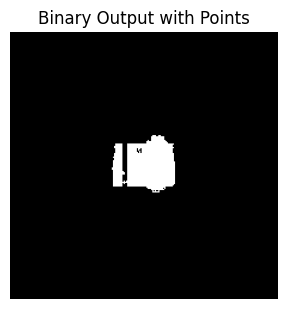

In [ ]:
num_runs = 1
image_files = glob.glob('./data_new/*.png')

for run in range(num_runs):
    # Randomly select one image
    target_image_path = random.choice(image_files)
    target_image = Image.open(target_image_path).convert('L')
    target_image = pil_to_binary(target_image)
    # Save target image to plots directory
    os.makedirs(f"./plots/{run}", exist_ok=True)
    plt.imsave(f"./plots/{run}/target_image.png", target_image, cmap='gray')

    # Random agent simulation
    # Assuming target_image is a numpy array or similar object
    width, height = target_image.shape  # .shape is an attribute, not a method
    print(width, height)
    
    num_samples = 15
    i=0
    
    # Create a black image
    image_black = np.zeros((width, height), dtype=np.int8)
    image_with_rays = image_black.copy()
    
    while (i<num_samples):
        # Generate random border and angle for ray shooting
        border = np.random.randint(2 * (width + height))
        angle = np.random.randint(360)
        
        # Perform ray shooting
        pixels, hit = shoot_ray(target_image, border, angle)
        
        if hit is None:
            continue
        else:
            image_black[hit[1], hit[0]] = 1
            image_with_rays[hit[1], hit[0]] = 1
            for pixel in pixels:
                image_with_rays[pixel[1], pixel[0]] = -1
    
        print(f"Selected Border Point (x, y): {border}")
        print(f"Ray Shooting Angle: {angle} degrees")
    
        print(f"Ray Shooting Result: (x, y) = ({hit[1]}, {hit[0]})")
        print(f"Angle for Ray: {angle} degrees")
        # Convert input array to a tensor suitable for the model
        input_tensor = torch.tensor(image_black, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        input_tensor_with_rays = torch.tensor(image_with_rays, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        input_tensor = input_tensor.unsqueeze(1)  # Add channel dimension
        input_tensor_with_rays = input_tensor_with_rays.unsqueeze(1)  # Add channel dimension
        input_tensor = input_tensor.to(device)  # Move the tensor to the GPU
        input_tensor_with_rays = input_tensor_with_rays.to(device)
    
        # Evaluate the model
        with torch.no_grad():  # Disable gradient calculation for evaluation
            output = model(input_tensor)  # Get the model's predictions
            output_with_rays = model(input_tensor_with_rays)
    
        # Convert the model output to a probability map and binary mask
        output_image = output[0][0].cpu().numpy()  # Get the first output channel as a numpy array
        output_image_with_rays = output_with_rays[0][0].cpu().numpy()  # Get the first output channel as a numpy array
        binary_output = (output_image > 0.5).astype(np.uint8)  # Thresholding to create a binary mask
        binary_output_with_rays = (output_image_with_rays > 0.5).astype(np.uint8)  # Thresholding to create a binary mask
    
        # Print shape of the output image and binary output for clarity
        print(f"Output Image Shape: {output_image.shape}")
        print(f"Binary Mask Shape: {binary_output.shape}")
    
        # Visualization using Matplotlib
        plt.figure(figsize=(20, 5))
    
        
    
        found_points = np.where(image_black == 1)
        plt.subplot(1, 5, 1)
        plt.imshow(binary_output, cmap='gray')
        #plt.scatter(found_points[1], found_points[0], color='green', s=10, label='Found Points')
        #if x is not None and y is not None:
        #    plt.scatter(y, x, color='red', s=25, label='Current Point')
        plt.title('Binary Output with Points')
        plt.axis('off')
        # Add an arrow for the angle
        #arrow_length = 20  # Adjust the length of the arrow
        #arrow_dx = arrow_length * np.cos(np.radians(angle))  # Calculate arrow x component
        #arrow_dy = arrow_length * np.sin(np.radians(angle))  # Calculate arrow y component
        #plt.arrow(border[1], border[0], arrow_dy, arrow_dx, head_width=5, head_length=10, fc='red', ec='red', label='Angle')

        #plot image with rays
        plt.subplot(1, 5, 4)
        plt.imshow(binary_output_with_rays, cmap='gray')
        plt.title('Binary Output with Rays')
        plt.axis('off')

        #probability heatmap with rays
        plt.subplot(1, 5, 5)
        plt.imshow(output_image_with_rays, cmap='jet')
        plt.title('Probability Heatmap with Rays')
        plt.axis('off')
    
        # Probability heatmap
        plt.subplot(1, 5, 2)
        plt.imshow(output_image, cmap='jet')
        plt.title('Probability Heatmap')
        plt.axis('off')
    
        plt.subplot(1, 5, 3)
        plt.imshow(target_image, cmap='gray')
        plt.title('Target Image')
        plt.axis('off')

        #Save the plot to /plots
        plt.savefig(f"./plots/{run}/{i}.png", bbox_inches='tight', dpi=100)
        plt.close()

        i = i+1